Мы уже решали задачу предсказания стоимости домов при помощи дерева. Тогда удалось добиться качества примерно
$R^2=0.5$ на кросс-валидации.

Немного. Попытаемся улучшить его путём подбора гиперпараметров.

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

In [ ]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Подберем гиперпараметры дерева по кросс-валидации по сетке при помощи GridSearchCV.

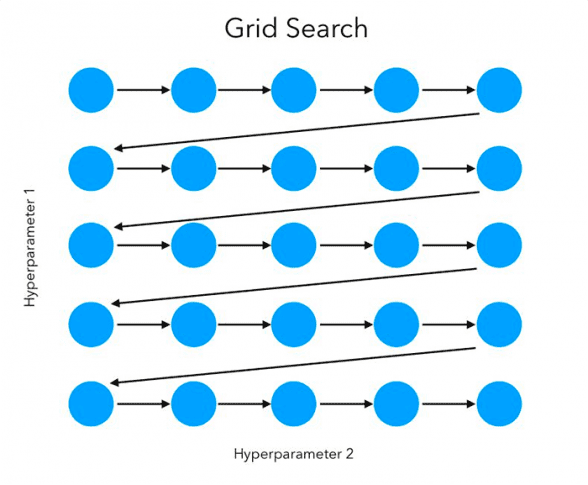

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

params = {'max_depth' : np.arange(2,10),
          'min_samples_split' : np.arange(2,10,2),
          'min_samples_leaf': np.arange(1,10,2)}

gs = GridSearchCV(DecisionTreeRegressor(), params, cv=3, scoring='r2', verbose=2)

gs.fit(X, y)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=8; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=8; total time=   0.0s
[CV] END max_depth=2, min_samples_l

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'min_samples_split': array([2, 4, 6, 8])},
             scoring='r2', verbose=2)

In [ ]:
gs.best_estimator_, gs.best_score_

(DecisionTreeRegressor(max_depth=5, min_samples_leaf=9), 0.5390892243233139)

Используем прунинг для уменьшения количества вершин в дереве и, следовательно, для снижения переобучения.

Прунинг при обучении дерева использует регуляризованный функционал
$$Q_{\alpha}(T) = Q(T) + \alpha |T|,$$
где $T$ - дерево, $Q(T)$ - функция потерь, $|T|$ - число вершин в дереве.

В sklearn есть Cost-Complexity pruning, который возвращает список возможных порогов $\alpha$ при построении дерева (т.к. данных конечное число, то не нужно рассматривать бесконечное число значений).

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

tree = DecisionTreeRegressor()

path = tree.cost_complexity_pruning_path(Xtrain, ytrain)
alphas = path['ccp_alphas']

alphas

array([0.00000000e+00, 5.73758669e-20, 5.73758669e-20, ...,
       7.95140486e-02, 1.01733053e-01, 4.20802794e-01])

In [ ]:
len(alphas)

13914

Чем больше $\alpha$, тем сильнее регуляризация, и тем меньше дерево переобучается.

Посмотрим на зависимость качества предсказания дерева на тренировочных и тестовых данных в зависимости от $\alpha$.

TQDM

Некоторые операции в python выполняются долго.
* Иногда прямо внутри функции есть параметр verbose, настроив который, можно узнать сколько уже итераций сделано.
* Если мы хотим посмотреть, как долго будет выполняться цикл, нам поможет библиотека tqdm

In [ ]:
from tqdm import tqdm

for i in tqdm(range(10000000)):
    pass

100%|██████████| 10000000/10000000 [00:02<00:00, 3871583.87it/s]


In [ ]:
import seaborn as sns
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

cv_score = []

for i in tqdm(alphas[::100]):
    tree = DecisionTreeRegressor(ccp_alpha = i)
    
    cv = cross_val_score(tree, X, y, cv=3, scoring='r2').mean()
    cv_score.append(cv)

100%|██████████| 140/140 [08:26<00:00,  3.62s/it]


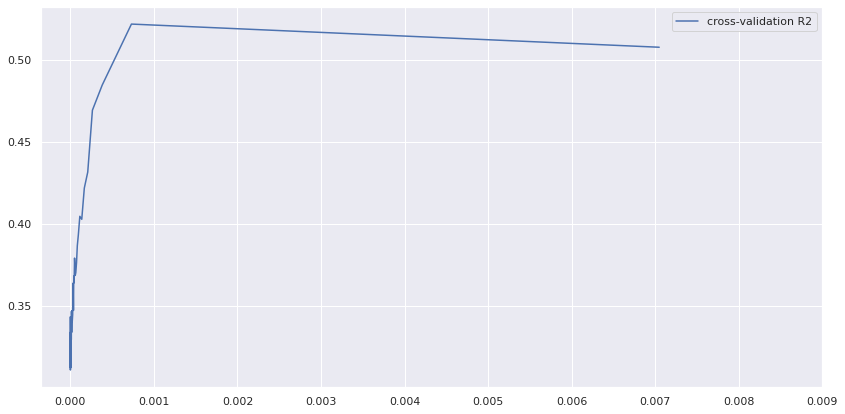

In [ ]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = cv_score, x = alphas[::100], label = "cross-validation R2")
plt.xticks(ticks = np.arange(0.00,0.01,0.001))
plt.show()

Мы видим, что аккуратный подбор гиперпараметра $\alpha$ при прунинге позволяет улучшить качество модели.

Также можно комбинировать прунинг и подбор других гиперпараметров - это долгая кропотливая работа.